+ test the transformation from noise correlation to noise power

In [4]:
%pylab inline
import imgutil
import galsim
import numpy as np
import astropy.io.fits as pyfits

Populating the interactive namespace from numpy and matplotlib


In [5]:
cd wrkDir/FPFS2/sim

/home/xiangchong/work/gw_ipmu/work/FPFS2/sim


In [6]:
ifield=1
# PSF preparation
psfPre='psfPre'
# Basic parameters
ngrid       =   64
scale       =   0.168
bigfft      =   galsim.GSParams(maximum_fft_size=10240)
flux_scaling=   2.587

# Get the psf and nosie information 
psfFname    =   os.path.join(psfPre,'psf%04d.fits'%(ifield))
psfImg      =   galsim.fits.read(psfFname)
noiseHead   =   pyfits.getheader(psfFname)
psfInt      =   galsim.InterpolatedImage(psfImg,scale=scale,flux = 1.) 
# Get the shear information
g1          =   noiseHead['g1']
g2          =   noiseHead['g2']
fwhm        =   noiseHead['fwhm'] 
variance    =   noiseHead['var']
rescale     =   noiseHead['rescale']

np.random.seed(ifield*10000+1)
corPre='corPre'
ud          =   galsim.UniformDeviate(ifield*10000+1)
corFname    =   os.path.join(corPre,'correlation.fits')
corNoise    =   galsim.getCOSMOSNoise(file_name=corFname,rng=ud,cosmos_scale=scale,variance=variance)

# Periodic Boundary
## From noise power to noise correlation

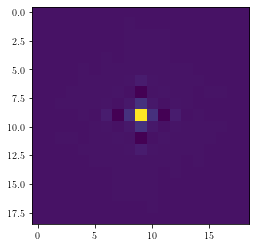

In [7]:
# Estimate Mean cor from noise
# power-> cor
corMea=np.zeros((ngrid,ngrid))
num=0
for i in range(1000):
    noi_image   =   galsim.ImageF(ngrid,ngrid,scale=scale)
    corNoise.applyTo(noi_image)
    noi_array=noi_image.array
    corMea+=np.fft.fftshift(np.fft.ifft2(np.abs(np.fft.fft2(noi_array))**2.)).real
    num+=1
corNum=np.fft.fftshift(np.fft.ifft2(np.abs(np.fft.fft2(np.ones((ngrid,ngrid))))**2.)).real
corMea=corMea/corNum
corMea=corMea[ngrid//2-9:ngrid//2+10,ngrid//2-9:ngrid//2+10]/num
plt.imshow(corMea)

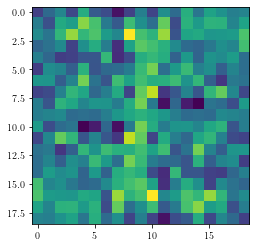

In [8]:
corIn=pyfits.getdata(corFname)*variance
corRes=corMea-corIn
plt.imshow(corRes)

# From noise correlation to noise power

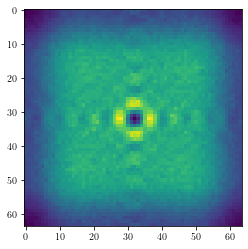

In [9]:
# Estimate Mean cor from noise
# cor -> pow
powMea=np.zeros((ngrid,ngrid))
num=0
for i in range(2000):
    noi_image   =   galsim.ImageF(ngrid,ngrid,scale=scale)
    corNoise.applyTo(noi_image)
    noi_array=noi_image.array
    powMea+=np.fft.fftshift(np.abs(np.fft.fft2(noi_array))**2.)
    num+=1
powMea=powMea/num
plt.imshow(powMea)

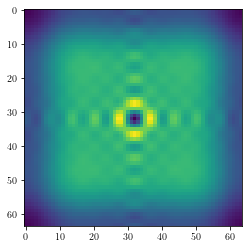

In [10]:
corNum=np.fft.fftshift(np.fft.ifft2(np.abs(np.fft.fft2(np.ones((ngrid,ngrid))))**2.)).real
corIn=pyfits.getdata(corFname)*variance
corIn=np.pad(corIn,(23,22))
corIn=corIn*corNum
powIn=np.fft.fftshift(np.fft.fft2(np.fft.fftshift(corIn)).real)
plt.imshow(powIn)

1.4880544636916326


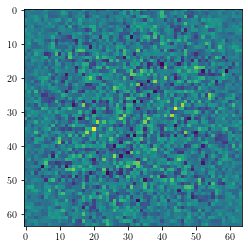

In [11]:
plt.imshow(powMea-powIn)
print(np.max(np.abs(powMea-powIn)))

## Test function fitNoiPow

In [12]:
powModel=np.zeros((1,ngrid,ngrid))
powModel[0]=powIn
for i in range(10):
    noi_image   =   galsim.ImageF(ngrid,ngrid,scale=scale)
    corNoise.applyTo(noi_image)
    noi_array=noi_image.array
    power=np.fft.fftshift(np.abs(np.fft.fft2(noi_array))**2.)
    subPow=imgutil.fitNoiPow(ngrid,power,powModel,18)
    print(np.average(subPow/powIn))

1.020637228290734
0.982888761812688
0.9567082184556098
0.9772322248261869
0.9930529919621396
1.0139780122368758
1.0372883326714428
0.9439127208688334
0.979738248500409
0.9565110489023367


## with galaxy image

In [47]:
# Get the  galaxy generator      
# Load data
index=1
catName     =   'real_galaxy_catalog_25.2.fits'
directory   =   '../../galsim_train/COSMOS_25.2_training_sample/'
cosmos_cat  =   galsim.COSMOSCatalog(catName, dir=directory)
# prepare the galaxies
gal0        =   cosmos_cat.makeGalaxy(gal_type='parametric',index=index,gsparams=bigfft)
gal0        *=  flux_scaling
final     =   galsim.Convolve([psfInt,gal0],gsparams=bigfft)

In [48]:
nrot        =   1
nx          =   1
ny          =   10
ndata       =   nx*ny
# setup the galaxy image and the noise image
gal_image   =   galsim.ImageF(nx*ngrid,ny*ngrid,scale=scale)
gal_image.setOrigin(0,0)
data_rows   =   []

for i in range(ny):
    # Prepare the subimage
    ix      =   0
    iy      =   i
    b       =   galsim.BoundsI(ix*ngrid, (ix+1)*ngrid-1,iy*ngrid,(iy+1)*ngrid-1)
    sub_gal_image = gal_image[b]
    # Draw the galaxy image
    final.drawImage(sub_gal_image,method='no_pixel')

In [49]:
# Noise
corPre='corPre'
corFname    =   os.path.join(corPre,'correlation.fits')
corNoise    =   galsim.getCOSMOSNoise(file_name=corFname,rng=ud,cosmos_scale=scale,variance=variance)
corNoise.applyTo(gal_image)

galsim.Image(bounds=galsim.BoundsI(xmin=0, xmax=63, ymin=0, ymax=639), array=
array([[ 0.05112796,  0.03648877, -0.08129574, ..., -0.00101667,
         0.07089484, -0.00596743],
       [ 0.00627968, -0.07566416, -0.05915324, ..., -0.07439378,
        -0.05322221, -0.01115297],
       [-0.04332022,  0.0586802 ,  0.05904994, ...,  0.02351876,
        -0.00338287,  0.09385607],
       ...,
       [-0.04816497, -0.0227181 , -0.09348254, ..., -0.107141  ,
        -0.08327024,  0.01172333],
       [-0.04656021,  0.08067593,  0.01512975, ..., -0.00696027,
         0.01582786, -0.03192003],
       [-0.01880931,  0.11065299, -0.02190559, ...,  0.02656102,
         0.07129485,  0.05620999]], dtype=float32), wcs=galsim.OffsetWCS(0.168, galsim.PositionI(x=-1, y=-1), galsim.PositionD(x=0.0, y=0.0)))

(10, 64, 64)
0.9565110489023367


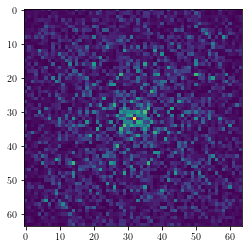

In [53]:
image_list=np.stack(np.vsplit(gal_image.array,10))
print(image_list.shape)
galPow=imgutil.getFouPow(image_list[0])
imshow(galPow)
subPow=imgutil.fitNoiPow(ngrid,power,powModel,18)
print(np.average(subPow/powIn))

In [56]:
for i in range(10):
    power=imgutil.getFouPow(image_list[i])
    subPow=imgutil.fitNoiPow(ngrid,power,powModel,18)
    print(np.average(subPow/powIn))

0.9800988861316728
1.0743035659992297
1.0354023612286325
1.027787556734634
0.9732356349527523
0.9059393173674285
0.9816185156411856
1.000468724565533
1.0292413156990838
1.0163988577476883
